In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use("seaborn")

from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order

# Introduction
`Cointegration` is a statistical property of a collection (X1, X2, ..., Xk) of time series variables. First, all of the series must be integrated of order d. Next, if a linear combination of this collection is integrated of order less than d, then the collection is said to be co-integrated. Formally, if (X,Y,Z) are each integrated of order d, and there exist coefficients a,b,c such that aX + bY + cZ is integrated of order less than d, then X, Y, and Z are cointegrated.

## Testing for Cointegration

We can use AEG (Augmented Engle-Granger) test to indicate whether we can reject the null that the two variables are not cointegrated. `statsmodels.tsa.stattools.coint(x1, x2, trend='c')`.

In [3]:
df = pd.read_csv("../data/df.csv")

In [4]:
def plot_data(df, title):
    Y = df.values
    T = Y.shape[0]
    fig, axes = plt.subplots(figsize=(12,6))

    axes.plot(np.arange(T), Y[:,0], label = "Y1")
    axes.plot(np.arange(T), Y[:,1], label = "Y2")
    axes.set_xlabel('Period', fontsize=18)
    axes.set_ylabel('Y', fontsize=18)
    axes.set_title(title, fontsize=18)
    axes.axhline(y=0, linewidth=0.4)
    axes.legend(loc='lower right', ncol=1)

    fig.tight_layout()

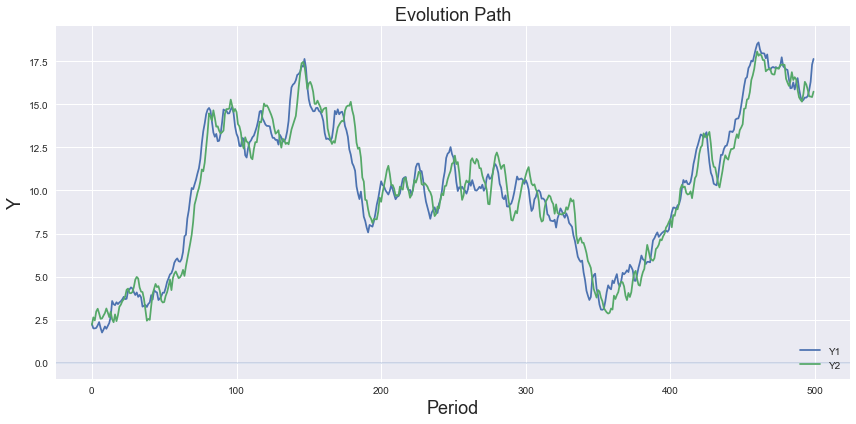

In [5]:
plot_data(df, "Evolution Path")

In [6]:
def ADF_test(df): 
    for j in range(0, df.shape[1]):
        adf_result1 = sm.tsa.stattools.adfuller(df.iloc[:,j])
        print('\tY'+str(j)+': ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result1[0], adf_result1[1]),
                      '\n\tcritical values', adf_result1[4],'\n')

In [7]:
print("ADF test:")
ADF_test(df)
print("ADF test first diff:")
ADF_test(df.diff().dropna())

ADF test:
	Y0: ADF statistic (p-value): -1.753 (0.404) 
	critical values {'1%': -3.4435494520411605, '5%': -2.8673612117611267, '10%': -2.5698704830567247} 

	Y1: ADF statistic (p-value): -1.985 (0.293) 
	critical values {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813} 

ADF test first diff:
	Y0: ADF statistic (p-value): -13.274 (0.000) 
	critical values {'1%': -3.4435494520411605, '5%': -2.8673612117611267, '10%': -2.5698704830567247} 

	Y1: ADF statistic (p-value): -14.680 (0.000) 
	critical values {'1%': -3.4435494520411605, '5%': -2.8673612117611267, '10%': -2.5698704830567247} 



The ADF tests suggest that we may not be able to reject the null that there is a unit-root for any of the two variables, but it indicates that we are able to reject the null of having a unit-root after first differencing the data. In other words, both series do look $I(1)$.

**Estmating the Cointegration Vector**
Let's now estimate the cointegrating vector for variables $(Y_1, Y_2)$ using **Dynamic OLS**. We can do this because simply using **OLS** gives us consistent (albeit inefficient) estimates. Using leads and lags can also help with inefficiency. To be more precise, we estimate the following regression by OLS:

$$
    Y_{1,t} = \alpha + \beta Y_{2,t} + \sum_{i=-k}^k b_{i, 2} \Delta Y_{2,t-i} + \varepsilon_{t}
$$

Let's use 5 leads and lags of the first differences of $\Delta Y_2$.

In [8]:
def coint(df, coint=None, dols_lags=5):
    """ 
    Function to calculate conintegration vector (if not given),
    or test wheather the residual (when the cointegration vector is given)
    is stationary or not. 
    
    Args:
        df: DataFrame, sample dataset.
        coint: np.array, the cointegration Vector, if None, then we estimate it by Dynamic OLS.
        dols_lags: int, default number of lags of Dynamic OLS.
    """
    if coint is None:
        dols_fit, alpha = dols_cointegrating_vec(df[['Y1']], df[['Y2']], k_lags=dols_lags, incl_trend=False)
        aeg_result = sm.tsa.stattools.coint(df['Y1'], df['Y2'], trend='c')
        print('\nAEG statistic (p-value): %0.3f (%0.3f)' % (aeg_result[0], aeg_result[1]),
              '\n(1%, 5%, 10%) critical values', aeg_result[2],'\n')
        return alpha
    else:
        resid  = df.values@coint
        
        adf_result1 = sm.tsa.stattools.adfuller(resid)
        print('\nCoint resid: ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result1[0], adf_result1[1]),
                      '\ncritical values', adf_result1[4],'\n')
    
        
def dols_cointegrating_vec(df_y, df_x, k_lags=5, incl_trend=False):
    """
    Function to compute conintegration vec using Danymic OLS.
    
    Args:
        df_y: pd.Series, dependent variable in Danymic OLS.
        df_x: pd.DataFrame, independent variables in Danymic OLS.
        k_lags: int, number of lags in equations.
        incl_trend: bool, whether include trend or not in regression.
    """
    df_dx = df_x.diff(1)
    XX = df_x
    for klag in range(1,k_lags):
        xl = df_dx.shift(klag)
        xl.columns = [l + str(klag) for l in xl.columns]
        XX = pd.concat([XX, xl], axis=1)
        xl = df_dx.shift(-klag)
        xl.columns = [l + str(-klag) for l in xl.columns]
        XX = pd.concat([XX, xl], axis=1)
    XX = XX.iloc[k_lags:-k_lags+1]
    Y  = df_y.iloc[k_lags:-k_lags+1]
    dols_fit = sm.OLS(Y, sm.add_constant(XX), missing='drop').fit()
    dols_fit = dols_fit.get_robustcov_results(cov_type='HAC', maxlags=k_lags)
    alpha = np.append(1,-dols_fit.params[1:1+np.shape(df[['Y2']])[1]])
    return dols_fit, alpha

In [9]:
alpha1 = coint(df)
print('Estimated cointegration vector: ', alpha1)

z1 = np.dot(df,alpha1)


AEG statistic (p-value): -6.955 (0.000) 
(1%, 5%, 10%) critical values [-3.91852234 -3.34840209 -3.05296032] 

Estimated cointegration vector:  [ 1.         -0.99749901]


Here the AEG (Augmented Engle-Granger) test indicates that we can reject the null that the two variables are not cointegrated. The estimation using dynamic OLS gives the cointegration vector of [1, -0.997].

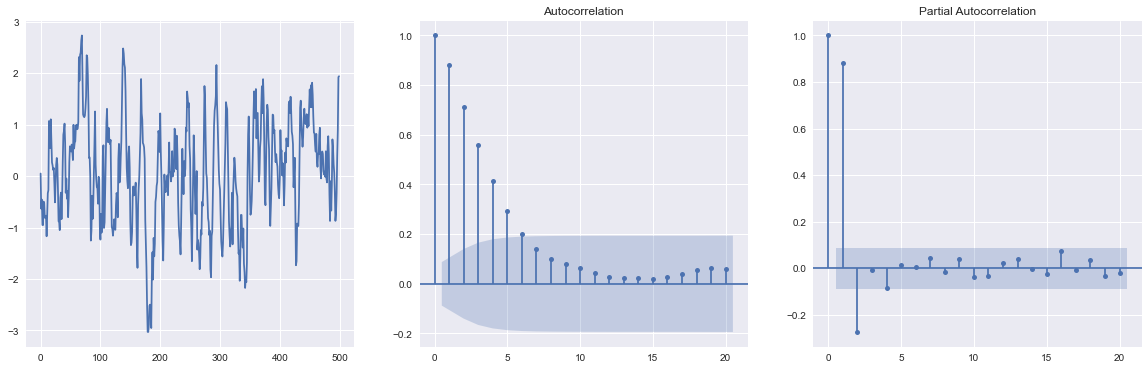

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))  
ax[0].plot(z1)
sm.tsa.graphics.plot_acf(z1, ax=ax[1], lags=20)
sm.tsa.graphics.plot_pacf(z1, ax=ax[2], lags=20)

plt.show()

The cointegration residuals look pretty stationary. The ACF/PACF plots show that the cointegration residuals seem to be an auto-regressive process.

### VECM

Let's now estimate the VECM($1$) associated with this model:

$$
\begin{align*}
    \Delta \mathbf{X}_t & = \mathbf{\nu} + \mathbf{\gamma} \mathbf{\widehat{\alpha}}^{\prime} \mathbf{X}_{t-1} + 
    \mathbf{\Gamma}(L)\Delta \mathbf{X}_{t-1} + \mathbf{\epsilon}_t\\[3mm]
\end{align*}
$$

In [12]:
X = df
print(select_order(X, maxlags=10).summary())
pstar = select_order(X, maxlags=10).bic

vecm_model = VECM(X, k_ar_diff=pstar, deterministic='co').fit()
gamma_vecm_statsmodels = vecm_model.alpha
alpha_vecm_statsmodels = vecm_model.beta

print("Estimated gamma : ", gamma_vecm_statsmodels.flat[:])
print("Estimated alpha : ", alpha_vecm_statsmodels.flat[:], '\n')
print(vecm_model.summary(), '\n')

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.287      -4.236     0.01374      -4.267
1      -4.631*     -4.545*   0.009749*     -4.597*
2       -4.627      -4.507    0.009782      -4.580
3       -4.630      -4.476    0.009756      -4.569
4       -4.616      -4.428    0.009888      -4.542
5       -4.606      -4.383    0.009994      -4.518
6       -4.599      -4.342     0.01006      -4.498
7       -4.584      -4.292     0.01022      -4.469
8       -4.574      -4.248     0.01032      -4.446
9       -4.564      -4.204     0.01042      -4.422
10      -4.555      -4.161     0.01052      -4.400
--------------------------------------------------
Estimated gamma :  [-0.00229534  0.22026208]
Estimated alpha :  [ 1.        -1.0123929] 

Det. terms outside the coint. relation & lagged endog. parameters for equation Y1
                 coef    std err          z      P>|z|      [0.